# 2 The gambler problem (3 pts.)

Consider the following problem, introduced in Chapter 4 of the Sutton and Barto book.  

A gambler is engaged in a betting game, where he must place bets on the outcomes of a sequence of coin
flips. Before each flip, the gambler decides how much to bet on the outcome that the coin will come up
heads—note that he can only decide how much to bet, not in which outcome to bet.  

If the coin does come up heads, the gambler doubles the money bet on that coin flip—in other words,
if the gambler bets $5 dollars, he will get his 5 dollars back plus another 5 dollars. If the coin comes up
tails, the gambler loses the money he bet. The game goes on until either the gambler reaches his goal of
100 dollars, or loses by running out of money. On each flip, the gambler must decide what portion of his
capital to stake, in integer numbers of dollars. Suppose that the probability of the coin coming up heads is
pH = 0.4.  

You will analyze the optimal betting policy for the gambler. To do so, model the gambler’s decision
problem as an MDP, specifying the state and action spaces, the transition probabilities and the reward
function. Make sure to use a reward function that only rewards the gambler for reaching his goal. Use a
discount γ = 1.  

**Question 2. Using the MDP model for the gambler problem, run value iteration. Plot, in the
same plot, the computed estimate for the optimal value function at iterations 1, 2, 3 and final (stop your
algorithm when the overall error is smaller than 10−8). Can you provide an interpretation for the values
obtained? Plot also the optimal policy computed.**  

Note: The gambler problem is somewhat numerically unstable, so to compute the optimal policy make
sure to rounded up all values to 4 decimal places.**

In [1]:
# Useful links:

# http://www.incompleteideas.net/book/first/ebook/node44.html
# We can initialize the problem as undiscounted and having only the goal state with reward 1

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

In [169]:
# Define a gambler class

class Gambler(object):
    
    def __init__(self, initial_budget=5, budget_goal=100, prob_heads=0.4, discount=1.0, error=10e-8):
        
        # Initialize the gambler's budget
        self.budget = int(initial_budget)
        
        # Initialize the target budget
        self.goal = int(budget_goal)
        
        # Initialize the probability of winning the coin flip
        self.prob_win = float(prob_heads)
        
        # Possible states: every value between 0 and 100, including
        self.states = np.arange(budget_goal + 1)
        
        # State values - Budget goal has maximum value
        self.state_values = np.zeros(budget_goal + 1)
        self.state_values[budget_goal] = 1
        
        # Discount factor. 1 is undiscounted
        self.discount = float(discount)
        
        # Error initialization
        self.error = float(error)
        
        # History placeholder
        self.history = []
        
        # Optimal policy
        self.optimal_policy = None
        
        # Get policy dataframe
        self.policy_df = None
        
        # Last Earnings
        self.last_earnings = None
        
        # Last budget
        self.last_budget = None
        
        # Play result
        self.play_result = None
        
        
    def value_iteration(self):
        
        iteration = 0
        self.history.append(copy.deepcopy(self.state_values))
        
        # Value iteration
        while True:
            delta = np.zeros(len(self.states))

            # We don't want to bet 0
            for state in self.states[1:-1]:
                current_value = self.state_values[state]
                #print(state)

                # Possible actions: betting between 1 and current budget (state)
                # If we have 95, we want to bet only 5 at max (goal - current state)
                current_actions = np.arange(min(state, self.goal - state) + 1)
                # print('State: {} \n Possible bets: {}'.format(state, current_actions))

                # What are the states we can end up in?
                # I.e. if we have 10 dollars, we can end up from any value from 0 to 10 + bet_amount
                # Calculated by following the transitions to the immediate next states.
                # I.e. sum of current action * the probability of following it and alternative action + probability of follow

                # We get an array of values for each next possible state
                state_prime_values = []
                for action in current_actions:
                    # the state we end up in is either budget + bet or budget - bet
                    # in this case is 0.4 * (budget + bet) or 0.6 * (budget - bet)
                    state_prime_win = self.prob_win * self.state_values[state + action]
                    state_prime_lose = (1 - self.prob_win) * self.state_values[state - action]
                    state_prime = state_prime_win + state_prime_lose

                    #print('State prime: {}'.format(state_prime))

                    # Add to possible state values
                    state_prime_values.append(state_prime)
                # print(state_prime_values)
                best_value = np.max(state_prime_values)
                #print(best_value)

                # Calculate the error for finishing the iteration
                current_delta = np.abs(current_value - best_value)
                delta[state] = max(delta[state], current_delta)
                #print(delta)
                
                # Update the value of the current state
                self.state_values[state] = best_value
                
                history = delta
                
            self.history.append(copy.deepcopy(self.state_values))

            if max(delta) < self.error:
                break
                
            
    def get_optimal_policy(self):
        # Get the policy
        # Optimal policy can be found by maximizing over q*(s, a)
        # We already have values of states, found by value iteration
        # v*(s) = max q*(s, a) over actions
        # Just need to pick the best action for each state
        
        policy_state = np.zeros(len(self.states))
        for state in self.states[1:]:
            # Get the action space for each state
            current_actions = np.arange(min(state, self.goal - state) + 1)
            
            
            # We get an array of values for each next possible state
            state_prime_values = []
            
            # Get the updated value for each action - calculated from value iteration
            # The best policy is the policy that maximizes the value of state and action
            for action in current_actions:
                state_prime_win = self.prob_win * self.state_values[state + action]
                state_prime_lose = (1 - self.prob_win) * self.state_values[state - action]
                state_prime = state_prime_win + state_prime_lose
                
                state_prime_values.append(state_prime)
                
            #print(state_prime_values)
            
            if (state == 0) or (state == 100):
                pass
            else:
                # Needed to add +1 because we're working with state_prime_values[1:]
                policy_state[state] = 1 + np.argmax(np.round(state_prime_values[1:], 4))
            
        self.optimal_policy = policy_state
        
        
    def get_policy_df(self):
        if self.optimal_policy is not None:
            self.policy_df = pd.DataFrame(self.optimal_policy.reshape(1, -1), columns=['Have {:003d}'.format(i) 
                                                                                       for i in np.arange(len(self.states))])
        return
        
        
    # Create an agent to follow the optimal policy created
    def play(self):
        
        previous_budget = None
        earnings = []
        budget = []
        
        # print('Starting with {} dollars'.format(self.budget))
        
        while True:
            if (self.budget == 0):
                # print('You lose!')
                self.play_result = 'Lose'
                break
            elif (self.budget == 100):
                # print('You win!')
                self.play_result = 'Win'
                break
            else:
                next_action = int(self.optimal_policy[self.budget])
                current_budget = self.budget
                
                if np.random.random(size=1) <= self.prob_win:
                    current_budget += next_action
                    earnings.append(next_action)
                    budget.append(current_budget)
                    # print('Agent won {} dolars! - Budget: {}'.format(next_action, current_budget))
                else:
                    current_budget -= next_action
                    earnings.append(-next_action)
                    budget.append(current_budget)
                    # print('Agent lost {} dolars! - Budget: {}'.format(next_action, current_budget))
                    
                if current_budget == self.budget:
                    # print('Agent got stuck, exiting')
                    self.play_result = 'Stuck'
                    break
                
                self.budget = current_budget
        
        self.last_budget = budget
        self.last_earnings = earnings
            
        return
        
        
    def gamble(self):
        self.value_iteration()
        self.get_optimal_policy()
        self.get_policy_df()
        self.play()
        
        return

In [170]:
# Example Gambler

example = Gambler(initial_budget=50)
example.gamble()

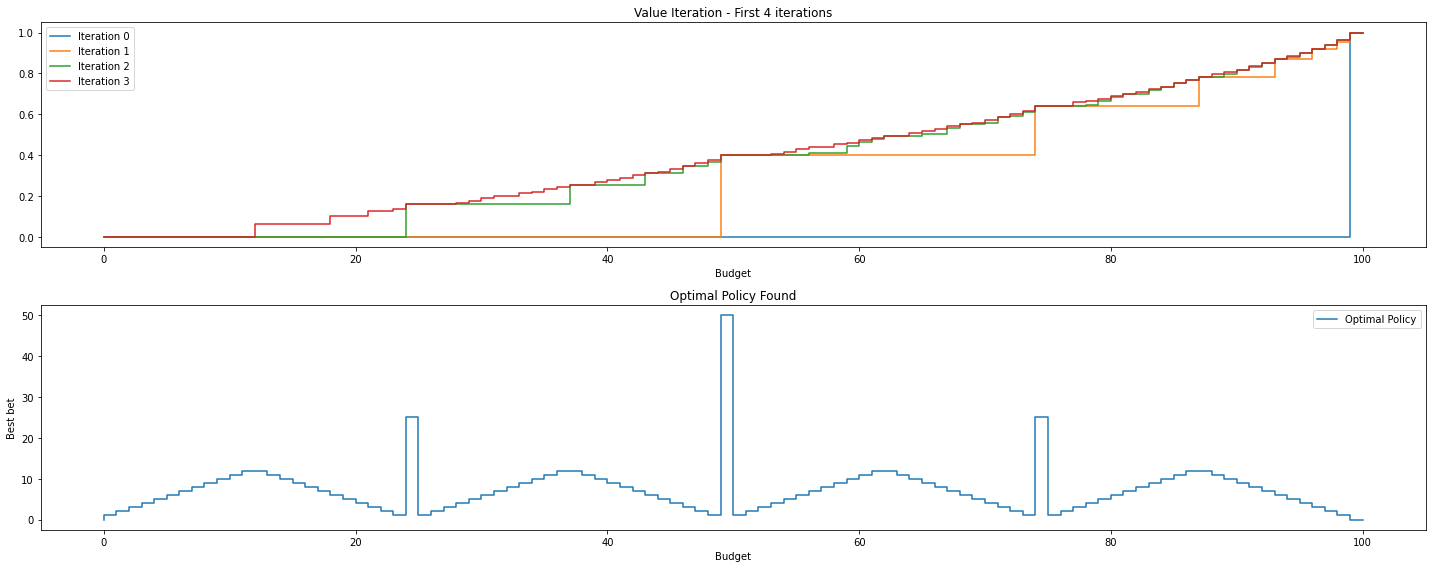

In [171]:
# Plot the first four iterations (including initial values) of history of the example and the optimal policy

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20, 8))

# first plot is iterations
axs[0].step(np.arange(101), example.history[0])
axs[0].step(np.arange(101), example.history[1])
axs[0].step(np.arange(101), example.history[2])
axs[0].step(np.arange(101), example.history[3])
axs[0].legend(['Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3'])
axs[0].set_title('Value Iteration - First 4 iterations')
axs[0].set_xlabel('Budget')
axs[1].set_ylabel('Value Estimate')

axs[1].step(np.arange(101), example.optimal_policy)
axs[1].legend(['Optimal Policy'])
axs[1].set_title('Optimal Policy Found')
axs[1].set_xlabel('Budget')
axs[1].set_ylabel('Best bet')

plt.tight_layout()
plt.show()

In [172]:
# Play 1000 games, with the initial values being randomized between 1 and 99

import tqdm

GAMBLE_RUNS = 1000
gamble_history = {}

for i in tqdm.notebook.trange(1, GAMBLE_RUNS + 1):
    gambler = Gambler(initial_budget=np.random.randint(1, 99))
    
    gambler.gamble()
    
    gamble_history['Gambler {:0004d}'.format(i)] = gambler

  0%|          | 0/1000 [00:00<?, ?it/s]

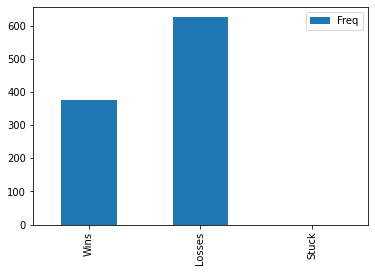

In [173]:
# let's analyse the game results

n_wins = 0
n_losses = 0
n_stuck = 0

for run in gamble_history:
    current_gambler = gamble_history[run]
    
    if current_gambler.play_result == 'Win':
        n_wins += 1
    elif current_gambler.play_result == 'Lose':
        n_losses += 1
    elif current_gambler.play_result == 'Stuck':
        n_stuck += 1
        
df = pd.DataFrame({'Wins': n_wins,
                   'Losses': n_losses,
                   'Stuck': n_stuck}, index=['Freq'])

df.transpose().plot(kind='bar')
plt.show()